In [5]:
# Helpers for multi-sweep comparisons
import pandas as pd
import numpy as np
import wandb

WRITE_FIG_DIR = '/cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/figures'


def fetch_sweep_df(sweep_path: str, timeout: int = 60, df_filepath: Path = None) -> pd.DataFrame:
    """Fetch runs for a W&B sweep path 'entity/project/sweep_id' into a tidy DataFrame.
    Returns DataFrame with columns: run_id, name, state, final/best_r2, model/num_parameters, plus a few config fields.
    """
    if df_filepath and df_filepath.exists():
        df = pd.read_csv(df_filepath)
        if not df.empty:
            return df
        
    api = wandb.Api(timeout=timeout)
    try:
        sweep = api.sweep(path=sweep_path)
    except Exception as e:
        print(f"Failed to load sweep {sweep_path}: {e}")
        return pd.DataFrame()

    recs = []
    for r in sweep.runs:
        s = dict(r.summary or {})
        c = dict(r.config or {})
        num_params = s.get("model/num_params") or s.get("model/num_parameters")
        epoch_loss = s.get("train/epoch_loss")
        recs.append({
            "run_id": r.id,
            "name": r.name,
            "state": r.state,
            "final/best_r2": s.get("final/best_r2"),
            "model/num_parameters": num_params,
            "train/epoch_loss": epoch_loss,
            "model.ssm_dim": c.get("model.ssm_dim"),
            "model.ssm_io_dim": c.get("model.ssm_io_dim"),
            "model.ssm_num_layers": c.get("model.ssm_num_layers"),
            "optimizer.lr": c.get("optimizer.lr"),
            "optimizer.weight_decay": c.get("optimizer.weight_decay"),
            "optimizer.mode": c.get("optimizer.mode"),
            "model.dropout_p": c.get("model.dropout_p"),
            "dataset_args.recording_id": c.get("dataset_args.recording_id"),
        })
    df = pd.DataFrame.from_records(recs)
    if df.empty:
        return df
    df = df.dropna(subset=["final/best_r2", "model/num_parameters"]).copy()
    df = df[df["model/num_parameters"] > 0]
    df.to_csv(df_filepath, index=False) if df_filepath else None
    return df


def compute_best_per_size(df: pd.DataFrame) -> pd.DataFrame:
    """Return the best-performing (max r2) run for each unique parameter count."""
    if df.empty:
        return df
    best = (
        df.sort_values(["model/num_parameters", "final/best_r2"], ascending=[True, False])
          .groupby("model/num_parameters", as_index=False)
          .first()
    )
    return best


def compute_pareto(best_per_size: pd.DataFrame) -> pd.DataFrame:
    """Pareto front where we minimize parameters and maximize r2.
    Expects best_per_size with columns model/num_parameters and final/best_r2.
    """
    if best_per_size.empty:
        return best_per_size
    pts = best_per_size[["model/num_parameters", "final/best_r2"]]
    pts = pts.sort_values(["model/num_parameters", "final/best_r2"], ascending=[True, False]).reset_index(drop=True)
    mask = np.zeros(len(pts), dtype=bool)
    current = -np.inf
    for i, row in pts.iterrows():
        r2 = row["final/best_r2"]
        if r2 > current:
            mask[i] = True
            current = r2
    return pts[mask].copy()


# Helpers to load minimal plot data and reconstruct DataFrames
import json
from pathlib import Path
from typing import Optional, List, Tuple

import pandas as pd


def load_plot_payload(json_path: Path) -> Optional[dict]:
    """Load saved minimal plot data safely. Returns dict or None if not readable."""
    try:
        if not json_path.exists():
            return None
        if json_path.stat().st_size < 2:  # too small to be valid JSON
            return None
        with open(json_path, "r", encoding="utf-8") as f:
            payload = json.load(f)
        # Basic schema check
        if not isinstance(payload, dict) or "datasets" not in payload:
            return None
        if not isinstance(payload["datasets"], list):
            return None
        return payload
    except Exception as e:
        print(f"Failed to load JSON from {json_path}: {e}")
        return None


def payload_to_results(payload: dict) -> List[Tuple[str, pd.DataFrame, pd.DataFrame]]:
    """Convert payload into list of (label, best_df, pareto_df) tuples."""
    out = []
    for ds in payload.get("datasets", []):
        label = ds.get("label", "unknown")
        b = ds.get("best_per_size", {})
        p = ds.get("pareto", {})
        best_df = pd.DataFrame({
            "model/num_parameters": b.get("params", []),
            "final/best_r2": b.get("r2", []),
        })
        pareto_df = pd.DataFrame({
            "model/num_parameters": p.get("params", []),
            "final/best_r2": p.get("r2", []),
        })
        out.append((label, best_df, pareto_df))
    return out

RTT: runs=927 best_per_size=22 pareto=8


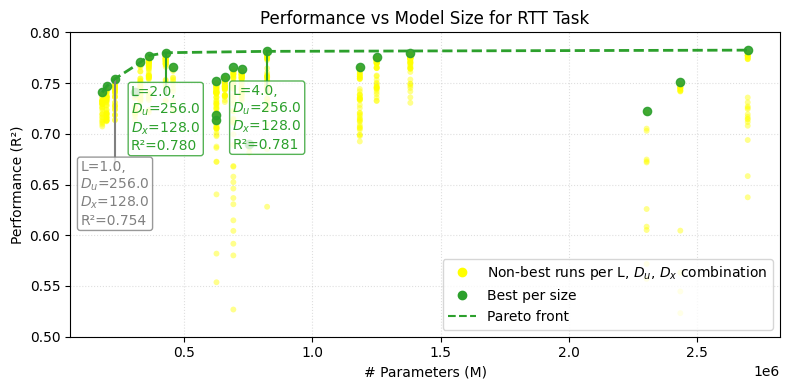

In [10]:
# Compare multiple sweeps: best-per-size and Pareto front overlays
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import json, os

# List of sweeps to compare; add more entries as needed
# Format: (label, "entity/project/sweep_id")
sweeps = [
    # ("Monkey T, CO 20130909", "melinajingting-ucl/foundational_ssm_pm_sweep/7liur42y"),
    ("RTT", "melinajingting-ucl/foundational_ssm_rtt_sweep/uqtrfg8h"),
    # ("Area2_Bump", "melinajingting-ucl/foundational_ssm_area2bump_sweep/ajypyzdr"),
]

# Optional color mapping; unknown labels will default to gray
colors = {
    "RTT": "tab:green",
}

dataframe_filepath = Path("results/Ultimate_RTT_sweep_data.csv")

fetched = []
for label, path in sweeps:
    df_s = fetch_sweep_df(path, df_filepath=dataframe_filepath)
    if df_s.empty:
        print(f"No data for {label} ({path})")
        continue
    df_s = df_s[df_s["optimizer.mode"] == "all"]
    best = compute_best_per_size(df_s)
    pareto = compute_pareto(best)
    fetched.append((label, df_s, best, pareto))
    colors.setdefault(label, 'gray')
    print(f"{label}: runs={len(df_s)} best_per_size={len(best)} pareto={len(pareto)}")
results = fetched


fig, ax = plt.subplots(figsize=(8, 4))
for label, df_all, best, pareto in results:
    c = colors.get(label, None)

    # Background: non-best runs in yellow
    if 'run_id' in df_all.columns and 'run_id' in best.columns:
        bg = df_all[~df_all['run_id'].isin(best['run_id'])]
    else:
        # Fallback: drop rows with identical (params, r2) to best
        bg = df_all.merge(best[["model/num_parameters", "final/best_r2"]],
                          on=["model/num_parameters", "final/best_r2"],
                          how="outer", indicator=True)
        bg = bg[bg['_merge'] == 'left_only']
    if not bg.empty:
        ax.scatter(bg["model/num_parameters"], bg["final/best_r2"], s=18, alpha=0.45,
                   color='yellow', edgecolor='none', zorder=1, label=None)

    # Best-per-size points
    ax.scatter(best["model/num_parameters"], best["final/best_r2"], s=35, alpha=0.9, color=c, zorder=2)

    # Pareto front (line)
    ax.plot(pareto["model/num_parameters"], pareto["final/best_r2"], lw=2, color=c, linestyle="--", zorder=3)

    # Annotate Pareto points with (num_layers, ssm_io_dim, ssm_dim)
    # Merge to recover config columns from best-per-size
    annot = pareto.merge(
        best[["model/num_parameters", "final/best_r2", "model.ssm_num_layers", "model.ssm_io_dim", "model.ssm_dim"]],
        on=["model/num_parameters", "final/best_r2"], how="left"
    ).drop_duplicates(subset=["model/num_parameters", "final/best_r2"])  # guard against dupes
    annot_2_4 = annot[(annot["model.ssm_io_dim"]==256) & (annot["model.ssm_dim"]==128) & (annot["model.ssm_num_layers"]>=2)]  # Filter for specific configurations
    for _, row in annot_2_4.iterrows():
        x = row["model/num_parameters"]; y = row["final/best_r2"]
        nl = row.get("model.ssm_num_layers", None)
        io = row.get("model.ssm_io_dim", None)
        wd = row.get("model.ssm_dim", None)
        r2 = row.get("final/best_r2", None)
        text = f"L={nl},\n" +r"$D_u$"+ f"={io}\n" + r"$D_x$" f"={wd}"+ f"\nR²={r2:.3f}"
        ax.annotate(text, xy=(x, y), xytext=(-25, -70), textcoords='offset points', fontsize=10, color=c,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=c, alpha=0.8))
        ax.plot([x, x], [y, y-0.04], color=c)
    
    annot_1 = annot[(annot["model.ssm_io_dim"]==256) & (annot["model.ssm_dim"]==128) & (annot["model.ssm_num_layers"]==1)]  # Filter for specific configurations
    for _, row in annot_1.iterrows():
        x = row["model/num_parameters"]; y = row["final/best_r2"]
        nl = row.get("model.ssm_num_layers", None)
        io = row.get("model.ssm_io_dim", None)
        wd = row.get("model.ssm_dim", None)
        r2 = row.get("final/best_r2", None)
        text = f"L={nl},\n" +r"$D_u$"+ f"={io}\n" + r"$D_x$" f"={wd}"+ f"\nR²={r2:.3f}"
        ax.annotate(text, xy=(x, y), xytext=(-25, -105), textcoords='offset points', fontsize=10, color='grey',
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec='grey', alpha=0.8))
        ax.plot([x, x], [y, y-0.09], color='grey')

# ax.set_xscale("log")
ax.set_xlabel("# Parameters (M)")
ax.set_ylabel("Performance (R²)")
ax.set_title("Performance vs Model Size for RTT Task")
ax.set_ylim(0.5,0.8)
ax.grid(True, which="both", ls=":", alpha=0.4)

# Single legend: yellow dot (non-best), green dot (best per size), dashed green (Pareto front)
if results:
    first_label = results[0][0]
    front_color = colors.get(first_label, 'tab:green')
else:
    front_color = 'tab:green'
style_handles = [
    Line2D([0], [0], marker='o', color='yellow', linestyle='None', markersize=6, label=f'Non-best runs per L, {r"$D_u$"}, {r"$D_x$"} combination'),
    Line2D([0], [0], marker='o', color=front_color, linestyle='None', markersize=6, label='Best per size'),
    Line2D([0], [0], color=front_color, linestyle='--', label='Pareto front'),
]
ax.legend(handles=style_handles, loc='lower right', frameon=True)

plt.tight_layout()
plt.savefig(os.path.join(WRITE_FIG_DIR, 'hyperparam_sweep_rtt.pdf'))
plt.show()

In [ ]:
# Compare multiple sweeps: best-per-size and Pareto front overlays
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import json, os

# List of sweeps to compare; add more entries as needed
# Format: (label, "entity/project/sweep_id")
sweeps = [
    ("RTT", "melinajingting-ucl/foundational_ssm_rtt_sweep/uqtrfg8h"),
]

# Optional color mapping; unknown labels will default to gray
colors = {
    "RTT": "tab:green",
}

# Try loading precomputed minimal results; else fetch and save
json_path = Path("results/pareto_plot_data.json")
dataframe_filepath = Path("results/Ultimate_RTT_sweep_data.csv")

payload = load_plot_payload(json_path)
results = []

fetched = []
for label, path in sweeps:
    df_s = fetch_sweep_df(path, df_filepath=dataframe_filepath)
    if df_s.empty:
        print(f"No data for {label} ({path})")
        continue
    df_s = df_s[df_s["optimizer.mode"] == "all"]
    best = compute_best_per_size(df_s)
    pareto = compute_pareto(best)
    fetched.append((label, df_s, best, pareto))
    colors.setdefault(label, 'gray')
    print(f"{label}: runs={len(df_s)} best_per_size={len(best)} pareto={len(pareto)}")
results = fetched


fig, ax = plt.subplots(figsize=(8, 5))
for label, df_all, best, pareto in results:
    c = colors.get(label, None)

    # Background: non-best runs in yellow
    if 'run_id' in df_all.columns and 'run_id' in best.columns:
        bg = df_all[~df_all['run_id'].isin(best['run_id'])]
    else:
        # Fallback: drop rows with identical (params, r2) to best
        bg = df_all.merge(best[["model/num_parameters", "final/best_r2"]],
                          on=["model/num_parameters", "final/best_r2"],
                          how="outer", indicator=True)
        bg = bg[bg['_merge'] == 'left_only']
    if not bg.empty:
        ax.scatter(bg["model/num_parameters"], bg["final/best_r2"], s=18, alpha=0.45,
                   color='yellow', edgecolor='none', zorder=1, label=None)

    # Best-per-size points
    ax.scatter(best["model/num_parameters"], best["final/best_r2"], s=35, alpha=0.9, color=c, zorder=2)

    # Pareto front (line)
    ax.plot(pareto["model/num_parameters"], pareto["final/best_r2"], lw=2, color=c, linestyle="--", zorder=3)

    # Annotate Pareto points with (num_layers, ssm_io_dim, ssm_dim)
    # Merge to recover config columns from best-per-size
    annot = pareto.merge(
        best[["model/num_parameters", "final/best_r2", "model.ssm_num_layers", "model.ssm_io_dim", "model.ssm_dim"]],
        on=["model/num_parameters", "final/best_r2"], how="left"
    ).drop_duplicates(subset=["model/num_parameters", "final/best_r2"])  # guard against dupes
    annot = annot[(annot["model.ssm_io_dim"]==256) & (annot["model.ssm_dim"]==128) & (annot["model.ssm_num_layers"]>=2)]  # Filter for specific configurations
    for _, row in annot.iterrows():
        x = row["model/num_parameters"]; y = row["final/best_r2"]
        nl = row.get("model.ssm_num_layers", None)
        io = row.get("model.ssm_io_dim", None)
        wd = row.get("model.ssm_dim", None)
        text = f"L={nl},\n" +r"$D_u$"+ f"={io}\n" + r"$D_x$" f"={wd}"
        ax.annotate(text, xy=(x, y), xytext=(-25, -38), textcoords='offset points', fontsize=10, color=c,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=c, alpha=0.8))

# ax.set_xscale("log")
ax.set_xlabel("# Parameters (M)")
ax.set_ylabel("Best R²")
ax.set_title("Pareto Frontier of Efficiency vs Performance for RTT Task")
ax.set_ylim(0.5,0.8)
ax.grid(True, which="both", ls=":", alpha=0.4)

# Legends: style legend (dot vs dash) and color legend (dataset name)
style_handles = [
    Line2D([0], [0], marker='o', color='yellow', linestyle='None', markersize=6, label='Non-best runs'),
    Line2D([0], [0], marker='o', color='k', linestyle='None', markersize=6, label='Best per size'),
    Line2D([0], [0], color='k', linestyle='--', label='Pareto front'),
]
leg1 = ax.legend(handles=style_handles, title='Style', loc='lower right', frameon=True)
ax.add_artist(leg1)

color_handles = [
    Line2D([0], [0], color=colors.get(label, 'gray'), linestyle='-', label=label)
    for (label, _, _, _) in results
]
ax.legend(handles=color_handles, title='Dataset', loc='lower left', frameon=True)

plt.tight_layout()
plt.savefig(os.path.join(WRITE_FIG_DIR, 'hyperparam_sweep_rtt.pdf'))
plt.show()


In [67]:
for label, path in sweeps:
    df_s = fetch_sweep_df(path, df_filepath=Path(os.path.join('results', f"{label.replace(' ', '_')}_sweep_data.csv")))  # no single-file caching; will save per-task below
    # if "optimizer.mode" in df_s.columns:
    #     df_s = df_s[df_s["optimizer.mode"] == "all"].copy()
    # out_csv = results_dir / f"{label.replace(' ', '_')}_sweep_data.csv"
    # df_s.to_csv(out_csv, index=False)
    # runs_by_task[label] = df_s[df_s['optimizer.lr']>=0.001]
    print(label)

RTT


A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.


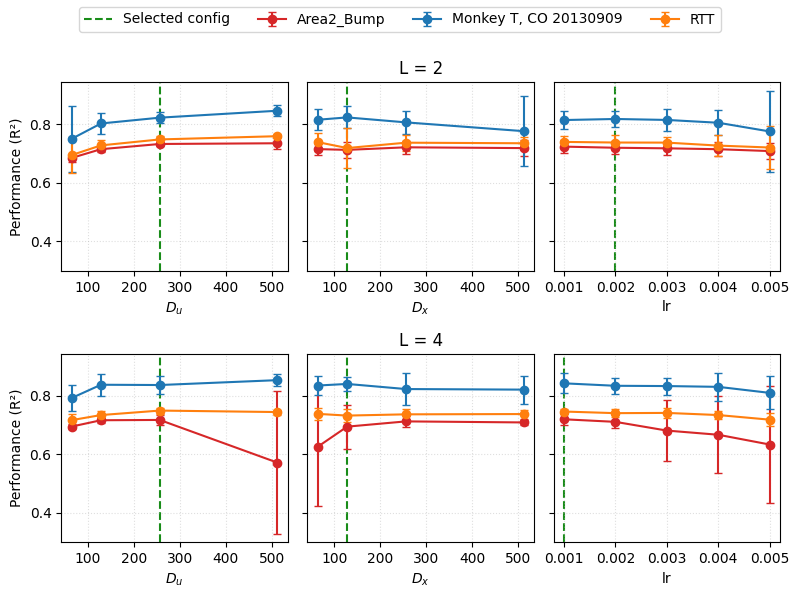

Saved aggregated table to results/robustness_agg.csv and figure to /cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/figures/hyperparam_sweep_robustness.pdf


In [69]:
# Robustness across depths (2, 4) and hyperparameters (D_u, D_x, lr)
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sweeps = [
    ("Monkey T, CO 20130909", "melinajingting-ucl/foundational_ssm_pm_sweep/7liur42y"),
    ("RTT", "melinajingting-ucl/foundational_ssm_rtt_sweep/kwwvplrp"),
    ("Area2_Bump", "melinajingting-ucl/foundational_ssm_area2bump_sweep/ajypyzdr"),
]

# Fetch runs for each sweep (uses helper defined earlier) and keep only optimizer.mode == 'all'
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

runs_by_task = {}
for label, path in sweeps:
    df_filepath = Path(os.path.join('results', f"{label.replace(' ', '_')}_sweep_data.csv"))
    df_s = fetch_sweep_df(path, df_filepath=df_filepath)  # no single-file caching; will save per-task below
    if "optimizer.mode" in df_s.columns:
        df_s = df_s[df_s["optimizer.mode"] == "all"].copy()
    out_csv = results_dir / f"{label.replace(' ', '_')}_sweep_data.csv"
    df_s.to_csv(out_csv, index=False)
    runs_by_task[label] = df_s[df_s['optimizer.lr']>=0.001]

# Aggregate mean/std for depths {2,4} over x in {D_u, D_x, lr}
X_COLS = [
    ("model.ssm_io_dim", r"$D_u$"),
    ("model.ssm_dim", r"$D_x$"),
    ("optimizer.lr", "lr"),
]
DEPTHS = [2, 4]

rows = []
for task, df in runs_by_task.items():
    # Ensure numeric types for grouping columns
    for col in ["model.ssm_io_dim", "model.ssm_dim", "optimizer.lr", "model.ssm_num_layers"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    for depth in DEPTHS:
        df_d = df[df["model.ssm_num_layers"] == depth].copy()
        if df_d.empty:
            continue
        for xcol, _ in X_COLS:
            if xcol not in df_d.columns:
                continue
            g = (
                df_d.dropna(subset=[xcol, "final/best_r2"]) 
                    .groupby(xcol)["final/best_r2"]
                    .agg(r2_mean="mean", r2_std=lambda v: v.std(ddof=1) if len(v) > 1 else 0.0, n="count")
                    .reset_index()
            )
            if g.empty:
                continue
            g.insert(0, "task", task)
            g.insert(1, "depth", depth)
            g.insert(2, "xcol", xcol)
            g = g.rename(columns={xcol: "xval"})
            rows.append(g)

robust_df = pd.concat(rows, axis=0, ignore_index=True) if rows else pd.DataFrame()
if robust_df.empty:
    raise RuntimeError("Robustness aggregation produced no rows.")

# Save aggregated table for future plots
agg_csv = results_dir / "robustness_agg.csv"
agg_parquet = results_dir / "robustness_agg.parquet"
try:
    robust_df.to_csv(agg_csv, index=False)
    robust_df.to_parquet(agg_parquet, index=False)
except Exception as e:
    print(f"Warning: failed to save aggregated tables: {e}")

# Plot: 2x3 grid (rows: depth in {2,4}; cols: x in {D_u, D_x, lr})
fig, axes = plt.subplots(len(DEPTHS), len(X_COLS), figsize=(8, 6), sharey=True)
if len(DEPTHS) == 1:
    axes = np.atleast_2d(axes)

# Use non-green colors for task lines so the reference line can be green
task_colors = {
    "Monkey T, CO 20130909": "tab:blue",
    "RTT": "tab:orange",
    "Area2_Bump": "tab:red",
}

# Reference configuration per depth (D_u, D_x, lr)
ref_by_depth = {
    2: {"model.ssm_io_dim": 256, "model.ssm_dim": 128, "optimizer.lr": 0.002},
    4: {"model.ssm_io_dim": 256, "model.ssm_dim": 128, "optimizer.lr": 0.001},
}

for r, depth in enumerate(DEPTHS):
    for c, (xcol, xlabel) in enumerate(X_COLS):
        ax = axes[r, c]
        sub = robust_df[(robust_df["depth"] == depth) & (robust_df["xcol"] == xcol)]

        # Draw the green reference line for this depth/xcol
        line_x = ref_by_depth.get(depth, {}).get(xcol)
        if line_x is not None:
            label = "Selected config" if (r == 0 and c == 0) else None
            ax.axvline(line_x, color="green", linestyle="--", linewidth=1.5, alpha=0.9, label=label, zorder=0)

        if sub.empty:
            ax.set_title(xlabel)
            ax.set_xlabel(xlabel)
            if xcol == "optimizer.lr":
                ax.set_xscale("log")
            if c == 0:
                ax.set_ylabel("Performance (mean ± std)")
            continue
        for task, df_t in sub.groupby("task"):
            color = task_colors.get(task, None)
            x = df_t["xval"].values
            order = np.argsort(x)
            x_sorted = x[order]
            m_sorted = df_t["r2_mean"].values[order]
            s_sorted = df_t["r2_std"].values[order]
            ax.errorbar(x_sorted, m_sorted, yerr=s_sorted, label=task, marker="o", capsize=3, linewidth=1.5, color=color)
        # ax.set_title(xlabel)
        ax.set_xlabel(xlabel)
        # if xcol == "optimizer.lr":
        #     ax.set_xscale("log")
        if c == 0:
            ax.set_ylabel("Performance (R²)")
        ax.grid(True, ls=":", alpha=0.4)

    # Add a row label centered above the row showing depth
    left = axes[r, 0].get_position().x0
    right = axes[r, -1].get_position().x1
    y_top = max(axr.get_position().y1 for axr in axes[r, :])

axes[0, 1].set_title("L = 2", fontsize=12)
axes[1, 1].set_title("L = 4", fontsize=12)

# One shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=len(task_colors) + 1, frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.93])
fig_path = os.path.join(WRITE_FIG_DIR, 'hyperparam_sweep_robustness.pdf')
plt.savefig(fig_path)
plt.show()
print(f"Saved aggregated table to {agg_csv} and figure to {fig_path}")

In [63]:
sub

,task,depth,xcol,xval,r2_mean,r2_std,n
15,RTT,4,optimizer.lr,0.001,0.712646,0.101374,48
16,RTT,4,optimizer.lr,0.002,0.636532,0.178399,45
17,RTT,4,optimizer.lr,0.003,0.557978,0.200392,50
18,RTT,4,optimizer.lr,0.004,0.477740,0.184711,50
19,RTT,4,optimizer.lr,0.005,0.444543,0.178142,45
